# PCA FOR PREDICTION OF "Failure Type"

To improve our model, we will try to apply PCA for each of our model to know whether we will apply PCA in the final model or not.

We will first deciding how much principal component we use, and apply the PCA on the training dataset on different models, via pipelin to avoid data leakage.

Importation of libraries

In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [5]:
!pip install xgboost
!pip install catboost
!pip install lightgbm

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

Loading our pre-created dataset (SMOTE and original versions, to use them according the tested model)

In [8]:
X_train = pd.read_csv("X_train.csv")
y_train_full = pd.read_csv("y_train.csv")
y_train = y_train_full['Failure Type']

X_train_smote = pd.read_csv("X_train_resampled_failure_type.csv")
y_train_resampled = pd.read_csv("y_train_resampled_failure_type.csv")
y_train_smote = y_train_resampled['Failure Type']

The covariance matrix stays the same as in the Notebook of PCAs for "Target" prediction, so we will not explained again but we choose to keep 1 or 2 Principal Components.

Creating the pipelines to test each model: one time with 1 pca and one time with 2 pcas.

First models are tested with SMOTE dataset
Second models are tested with original dataset

In [11]:
pca_components = 0.95  #basic value

In [12]:
#for models using dependencies between columns and which need their names
def restore_cols(X):
    return pd.DataFrame(X, columns=[f"f{i}" for i in range(X.shape[1])])


#weight class for CatBoost preidiction:
counts = np.bincount(y_train) 
total = len(y_train)
n_classes = len(counts)
class_weigth_catboost = [total / (n_classes * c) if c != 0 else 1.0 for c in counts]

#stocking our different pipelines in a dict: first, the models using smote dataset
pipelines_smote = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_components)),
        ("model", LogisticRegression(max_iter=500, multi_class="ovr")) #to use a binary conversion for each class
    ]),
    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_components)),
        ("model", SVC(kernel="rbf", probability=True))
    ]),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_components)),
        ("model", KNeighborsClassifier(n_neighbors=5))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_components)),
        ("model", MLPClassifier(hidden_layer_sizes=(50,50),
                                max_iter=1000,
                                learning_rate_init=0.01,
                                early_stopping=True,
                                n_iter_no_change=20,
                                validation_fraction=0.1,
                                random_state=42)) #i have icreased the max iter because 300 was not enough to converge
    ])
}

#stocking our different pipelines in a second dict: the models using original datase

pipelines = {
    "DecisionTree": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_components)),
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", DecisionTreeClassifier(class_weight='balanced'))#compensate with imbalanced dataset
    ]),

    "RandomForest": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_components)),
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", RandomForestClassifier(
            class_weight='balanced',#compensate with imbalanced dataset
            n_estimators=300, #more than the default value
        ))
    ]),

    "XGBoost": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_components)),
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", XGBClassifier(
            n_estimators=300,
            eval_metric="mlogloss",
            tree_method="hist"   #found to be the more optimal parameters here
        ))
    ]),

    "CatBoost": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_components)),
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", CatBoostClassifier(
            class_weights=class_weigth_catboost,
            logging_level="Silent" #to not print each step..
        ))
    ]),

    "LightGBM": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_components)),
        ("rename", FunctionTransformer(restore_cols)), #very important for LightGBM to work
        ("model", LGBMClassifier(
            n_estimators=300,
            verbose=-1,
            class_weight='balanced'
        ))
    ])
}

We wanted to try multiple values for our number of splits (3, 5 then 10) to check for the stability of the model and if its accuracy stays, but given the high number of models to test first we will only try with n = 5 at first.

The most relevant value for n is also found in the first predictions Notebook.

In [15]:
k = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [16]:
results = {} #stocking the results to print them

#call pipeline with different models and evaluating them
for name, model in pipelines_smote.items():
    results[name] = {}
    print(f"\n{name}, for 1 Principal Component:")
    pca_components = 1
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=k, scoring="recall_macro")
    print(f"Recall: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")
    results[name][1] = np.mean(scores)
    
    pca_components = 2
    print(f"\n{name}, for 2 Principal Components:")
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=k, scoring="recall_macro")
    print(f"Recall: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")
    results[name][2] = np.mean(scores)

    
for name, model in pipelines.items():
    results[name] = {}
    pca_components = 1
    print(f"\n{name}, for 1 Principal Component:")
    scores = cross_val_score(model, X_train, y_train, cv=k, scoring="recall_macro")
    print(f"Recall: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")
    results[name][1] = np.mean(scores)
    
    pca_components = 2
    scores = cross_val_score(model, X_train, y_train, cv=k, scoring="recall_macro")
    print(f"\n{name}, for 2 Principal Components:")
    print(f"Recall: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")
    results[name][2] = np.mean(scores)
    


Logistic Regression, for 1 Principal Component:
Recall: 0.5949
Standard deviation: 0.0317

Logistic Regression, for 2 Principal Components:
Recall: 0.5949
Standard deviation: 0.0317

SVM, for 1 Principal Component:
Recall: 0.7062
Standard deviation: 0.0516

SVM, for 2 Principal Components:
Recall: 0.7062
Standard deviation: 0.0516

KNN, for 1 Principal Component:
Recall: 0.6172
Standard deviation: 0.0377

KNN, for 2 Principal Components:
Recall: 0.6172
Standard deviation: 0.0377

Neural Network, for 1 Principal Component:
Recall: 0.7000
Standard deviation: 0.0389

Neural Network, for 2 Principal Components:
Recall: 0.7000
Standard deviation: 0.0389

DecisionTree, for 1 Principal Component:
Recall: 0.3615
Standard deviation: 0.0165

DecisionTree, for 2 Principal Components:
Recall: 0.3641
Standard deviation: 0.0232

RandomForest, for 1 Principal Component:
Recall: 0.3236
Standard deviation: 0.0042

RandomForest, for 2 Principal Components:
Recall: 0.3187
Standard deviation: 0.0072

XGB

To compare with the results of the first prediction (without PCAs):

In [18]:
results_df = pd.DataFrame(results)
print(results_df)

   Logistic Regression       SVM       KNN  Neural Network  DecisionTree  \
1             0.594872  0.706227  0.617216             0.7      0.361483   
2             0.594872  0.706227  0.617216             0.7      0.364132   

   RandomForest   XGBoost  CatBoost  LightGBM  
1      0.323606  0.371402  0.538871   0.38367  
2      0.318710  0.371402  0.538871   0.38367  


Final comparison of each model based on their Recall value for each value of k fold

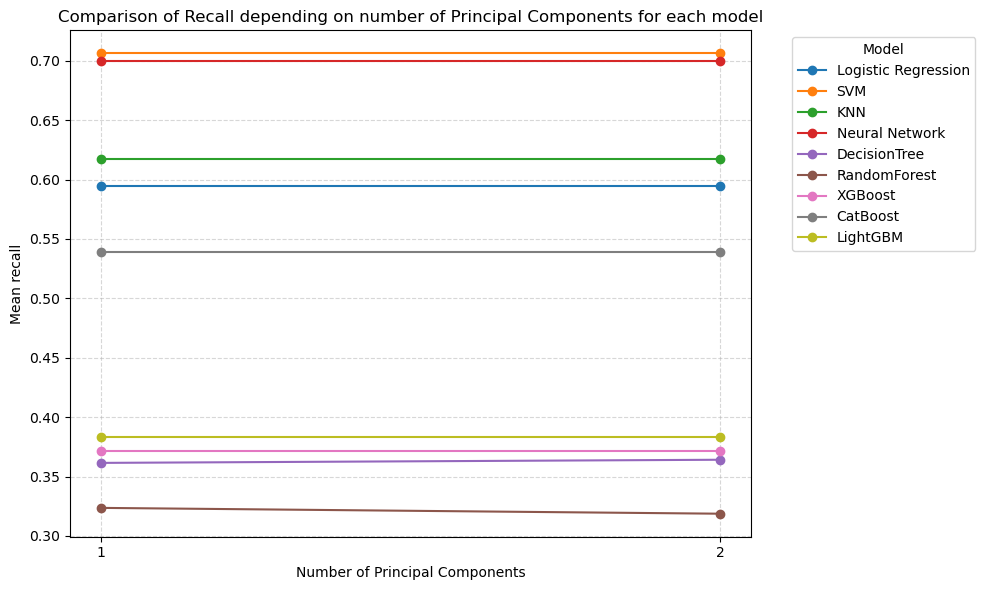

In [28]:
plt.figure(figsize=(10, 6))

for name in results.keys():
    pcas = list(results[name].keys())
    recalls = list(results[name].values())
    plt.plot(pcas, recalls, marker="o", label=name)

plt.title("Comparison of Recall depending on number of Principal Components for each model")
plt.xlabel("Number of Principal Components")
plt.ylabel("Mean recall")
plt.xticks([1,2])
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

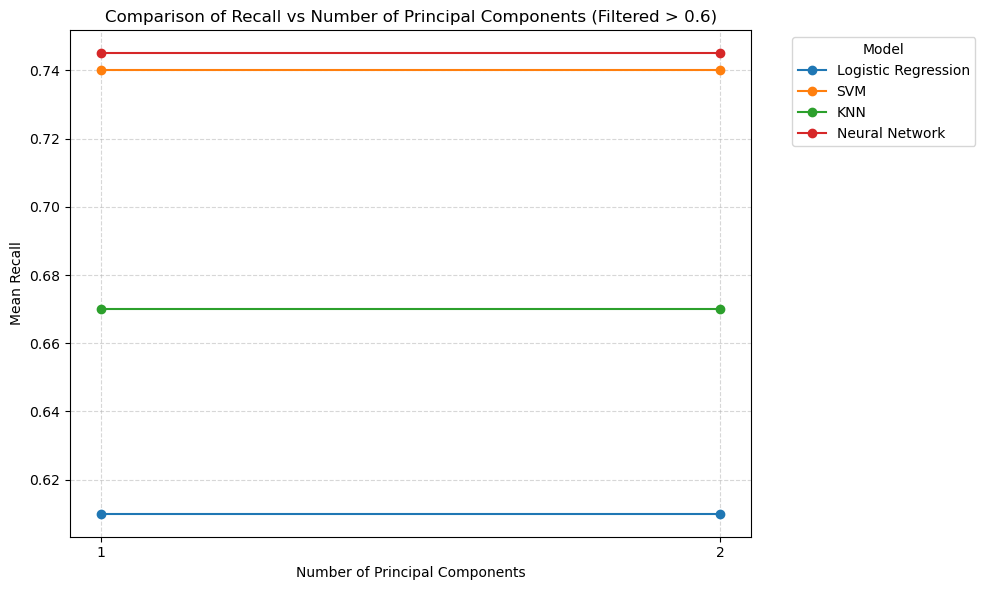

In [14]:
plt.figure(figsize=(10, 6))

for name, values in results.items():
    pcas = list(values.keys())
    recalls = list(values.values())
    if max(recalls) > 0.6:
        plt.plot(pcas, recalls, marker="o", label=name)

plt.title("Comparison of Recall vs Number of Principal Components (Filtered > 0.6)")
plt.xlabel("Number of Principal Components")
plt.ylabel("Mean Recall")
plt.xticks([1, 2])
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### Analysis

We notice that for ensemble models, PCA is irrelevant and not pertinent because it reduces dimension and avoid decision by treeshold and tree. So for ensemble models, we will not use PCA.

For the simple models, which use SMOTE, there is no difference between 1 or 2 Principal Components, so only 1 Principal Component might be used if we keep PCA. We compared the result with the one found without PCA (notebook "First models for Target prediction").

As saw in the first prediction for Failure Type, we will keep the models **CatBoost**, **Random Forest**, **Neural Network** and **LightGBM**

It can be relevant to apply PCAs on non-ensemble models so only Neural Network. 


Without PCA, it had a very low recall (0.51 for 3 split of Stratified Cross-Validation, 0.27 for 10), but here it rised to 0.745 (with k=5) and 0.7 (with k=3) **so it is in fact relevant to apply PCA for Neural Network in the prediction of Failure Type only.**
